# Antonia Villarino - BDTHackaton

# LHC particle classification

## BACKGROUND
The LHC (Large Hadron Collider) is a particle accelerator located in Geneva (Switzerland). A particle accelerator is a ring that brings beams of particles to near the speed of light, using super-strong magnetic fields.

Once the particles collide, they disintegrate into their more fundamental elements: other particles like leptons, quarks, gluons... These particles decay very quickly and it wouldn't be possible to study them without an accelerator.

## GOAL
The goal for this challenge is to **predict which particle was produced** in the hadron collision. To do that, we have a dataset with **more than 125,000 observations**. The dataset is **labeled**: that is, we know the type of particle for each observation. All of this means that we are faced with a **supervised multi-class classification problem**.

### Import libraries and dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('tab10', 7)

random_seed = 42

In [2]:
# load the particle dataset
data_particles = pd.read_csv('data/particles.csv')
print(data_particles.shape)
data_particles.head()

(127321, 12)


,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
0,NaN,-59.730861,396.928620,9.761703,-137.558889,159.598109,-137.558889,53.930955,154.713810,-232.436087,99.243140,3
1,147.781782,153.729532,111.998962,-174.941235,-97.888332,26.493593,-97.888332,-30.506871,-166.347802,-195.010710,20.242743,0
2,242.220616,82.947635,-102.073856,116.334349,-101.746729,176.452823,-101.746729,-33.419984,44.082548,-173.928682,3.806943,1
3,140.542086,-110.129037,215.560355,-11.927860,-11.257902,21.648833,-11.257902,240.685680,133.441269,-276.382025,0.336025,0
4,169.367809,-92.182925,159.995515,-272.230740,-80.483153,-97.698901,-80.483153,16.251613,-13.177148,-100.316959,24.459551,0


## Exploratory Data Analysis

### Missing values

What is the ratio of missing values per column?

alpha_1     0.142859
gamma_3     0.074018
gamma_2     0.005710
theta       0.005702
beta_2      0.001492
beta_3      0.000903
alpha_2     0.000000
alpha_3     0.000000
beta_1      0.000000
gamma_1     0.000000
noise       0.000000
Particle    0.000000
dtype: float64

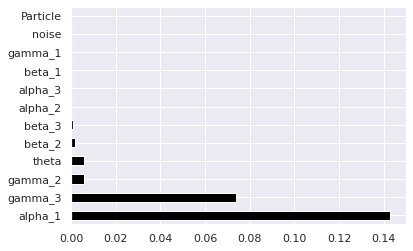

In [3]:
# ratio of missing values per column
missing_values = (data_particles.isna().sum()/ data_particles.shape[0]).sort_values(ascending=False)
missing_values.plot(kind='barh', color='black')
missing_values

**alpha_1 has 14% of missing values, and gamma_3, a 7%**

### Distribution of the target and variables

The target, *'Particles'*, is **imbalanced**, because the first 4 particle types are much more populated:

Text(0.5, 1.0, 'Ratio for each type of particle')

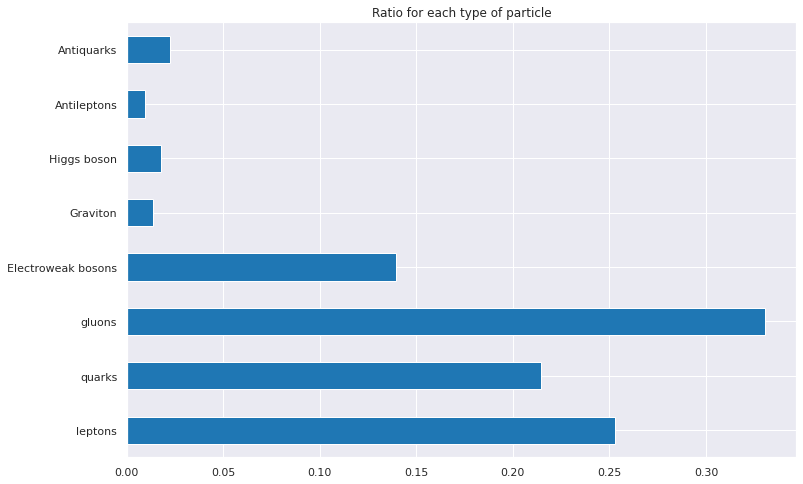

In [4]:
# define a dictionary to keep the relationship between number and type of particle
map_type_particles = {0:'leptons', 1:'quarks', 2:'gluons', 3:'Electroweak bosons', 4:'Graviton', 5:'Higgs boson', 6:'Antileptons', 7:'Antiquarks'}

# compute the ratio of each type of particle
particle_count = data_particles['Particle'].value_counts(normalize=True).sort_index()

# plot
fig, ax = plt.subplots(figsize=(12, 8))

particle_count.plot(kind='barh', ax=ax)

ax.set_yticklabels(map_type_particles.values())
ax.set_title(f'Ratio for each type of particle')

In fact, the *leptons*, *quarks*, *gluons* and *Electroweak bosons* add up to the **94%** of the particle total number

In [5]:
# sum the ratios of the first 4 types of particle
particle_count.iloc[:4].sum()

0.937190251411786

The other features are all **normal-like distributions**, except for *'noise'*. They seem to be centered on 0, but not exactly. Their **standard deviations** are on the **same order of magnitude**:

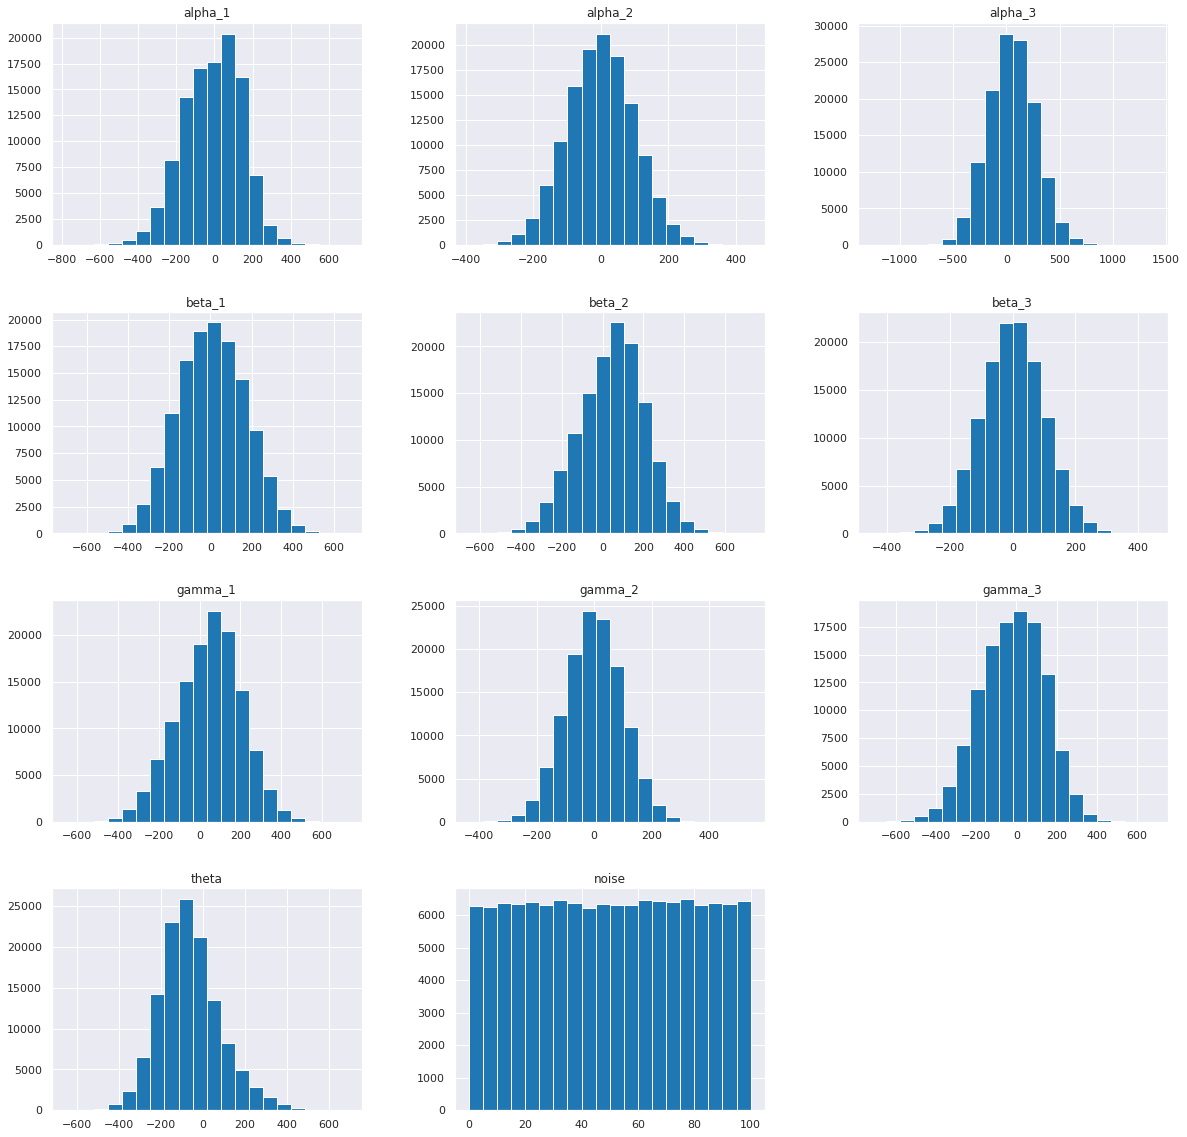

In [6]:
axes = data_particles.drop(columns=['Particle']).hist(figsize=(20, 20), bins=20)

Let's compute the standard deviations, to be sure that they are all similar (except, again, *'noise'*):

In [7]:
data_particles.std()

alpha_1     152.987128
alpha_2     100.044696
alpha_3     221.503776
beta_1      164.993428
beta_2      160.134335
beta_3       99.979061
gamma_1     160.142626
gamma_2      99.797656
gamma_3     160.637008
theta       146.954921
noise        28.848755
Particle      1.470649
dtype: float64

### Bivariate plots with target

Now I want to see how the variables change across the particle types.
I'm going to use violin plots because they show very clearly is there is any variation in the distribution and median of the variable across the classes:

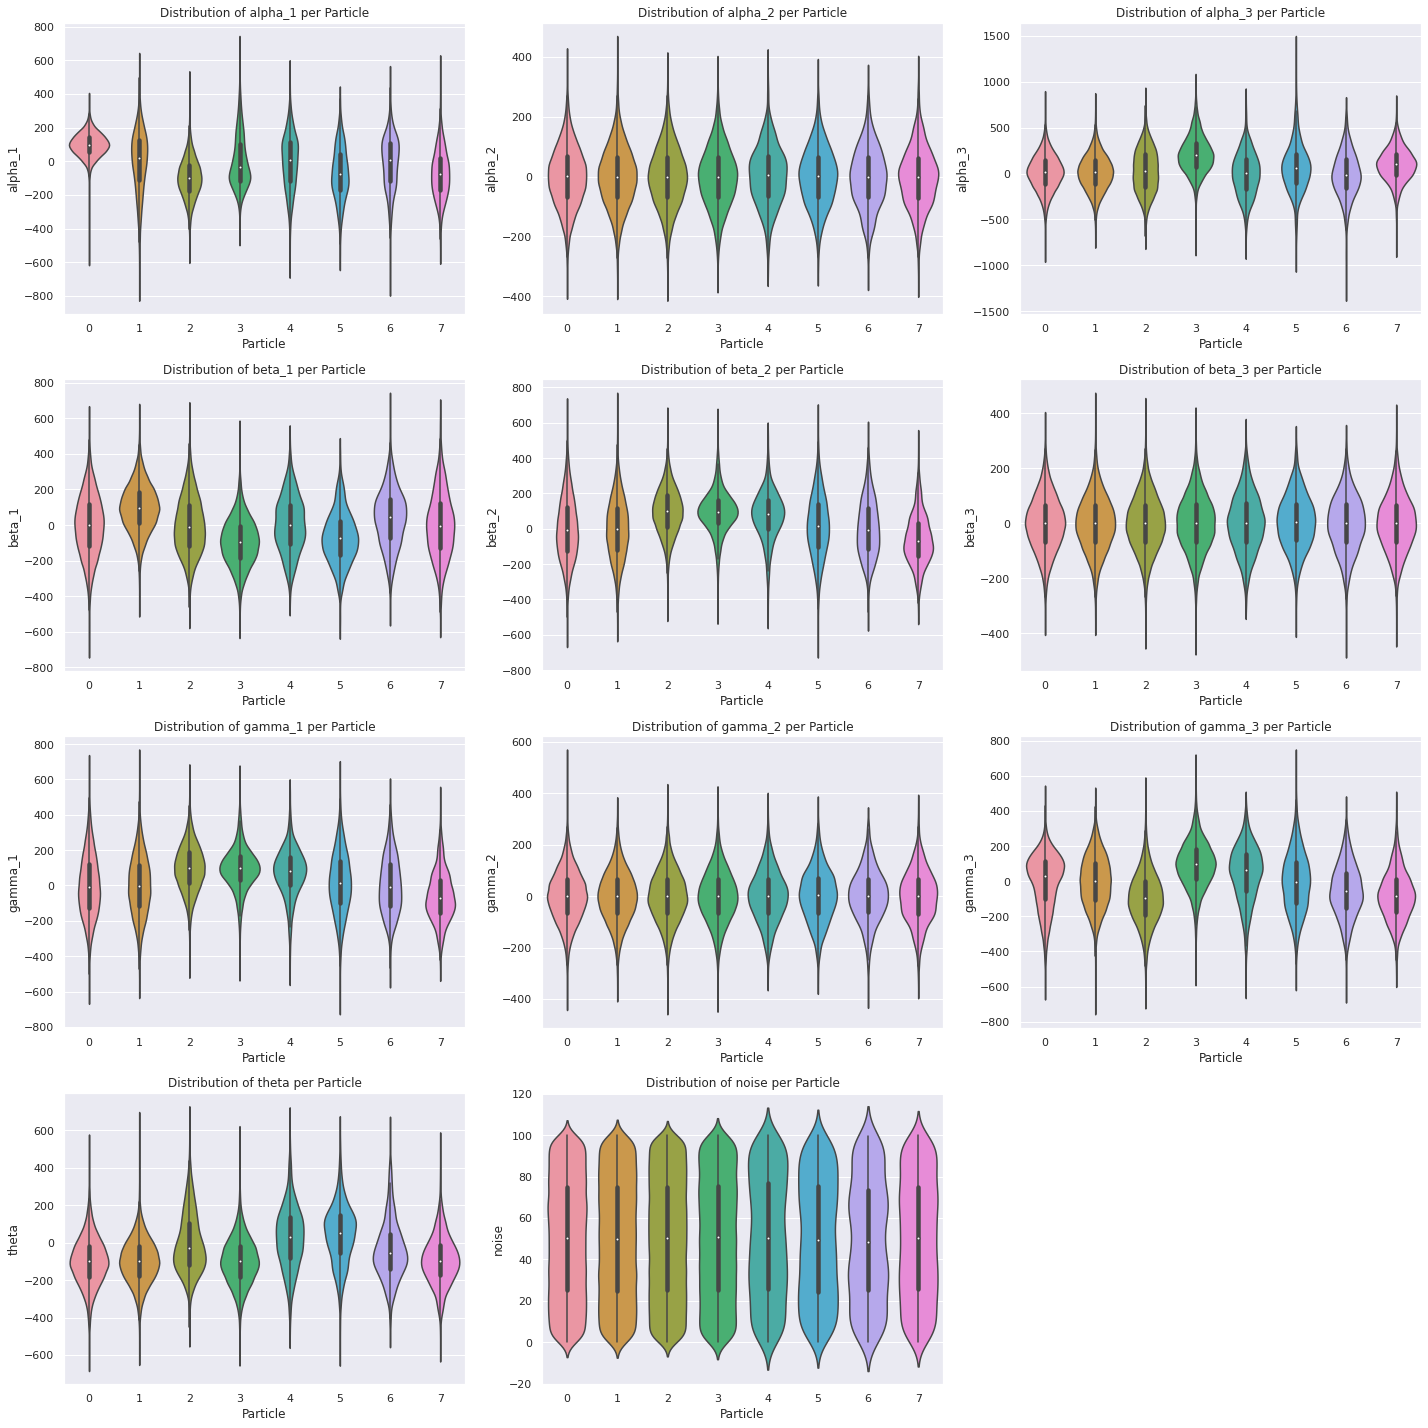

In [8]:
# make bivariate plots with the target
column_names = data_particles.drop(columns=['Particle']).columns

# number of columns and rows of the grid of plots
ncols = 3
nrows = int(np.ceil(len(column_names) / ncols))

fig = plt.figure(figsize=(20, 20))
# iterate through all the variables
for i, col in enumerate(column_names):
    # add a subplot in the (i+1)th position
    ax = fig.add_subplot(nrows, ncols, i+1)
    # plot the variable vs the target (Particle)
    ax = sns.violinplot(x='Particle', y=col, data=data_particles)
    ax.set_title(f'Distribution of {col} per Particle')

plt.tight_layout()

*alpha_2*, *beta_3*, *gamma_2* don't vary much from particle type to particle type. This four columns are **good candidates to drop** to enhance the model.

###  Histogram plots of the variables, discriminating type of particle

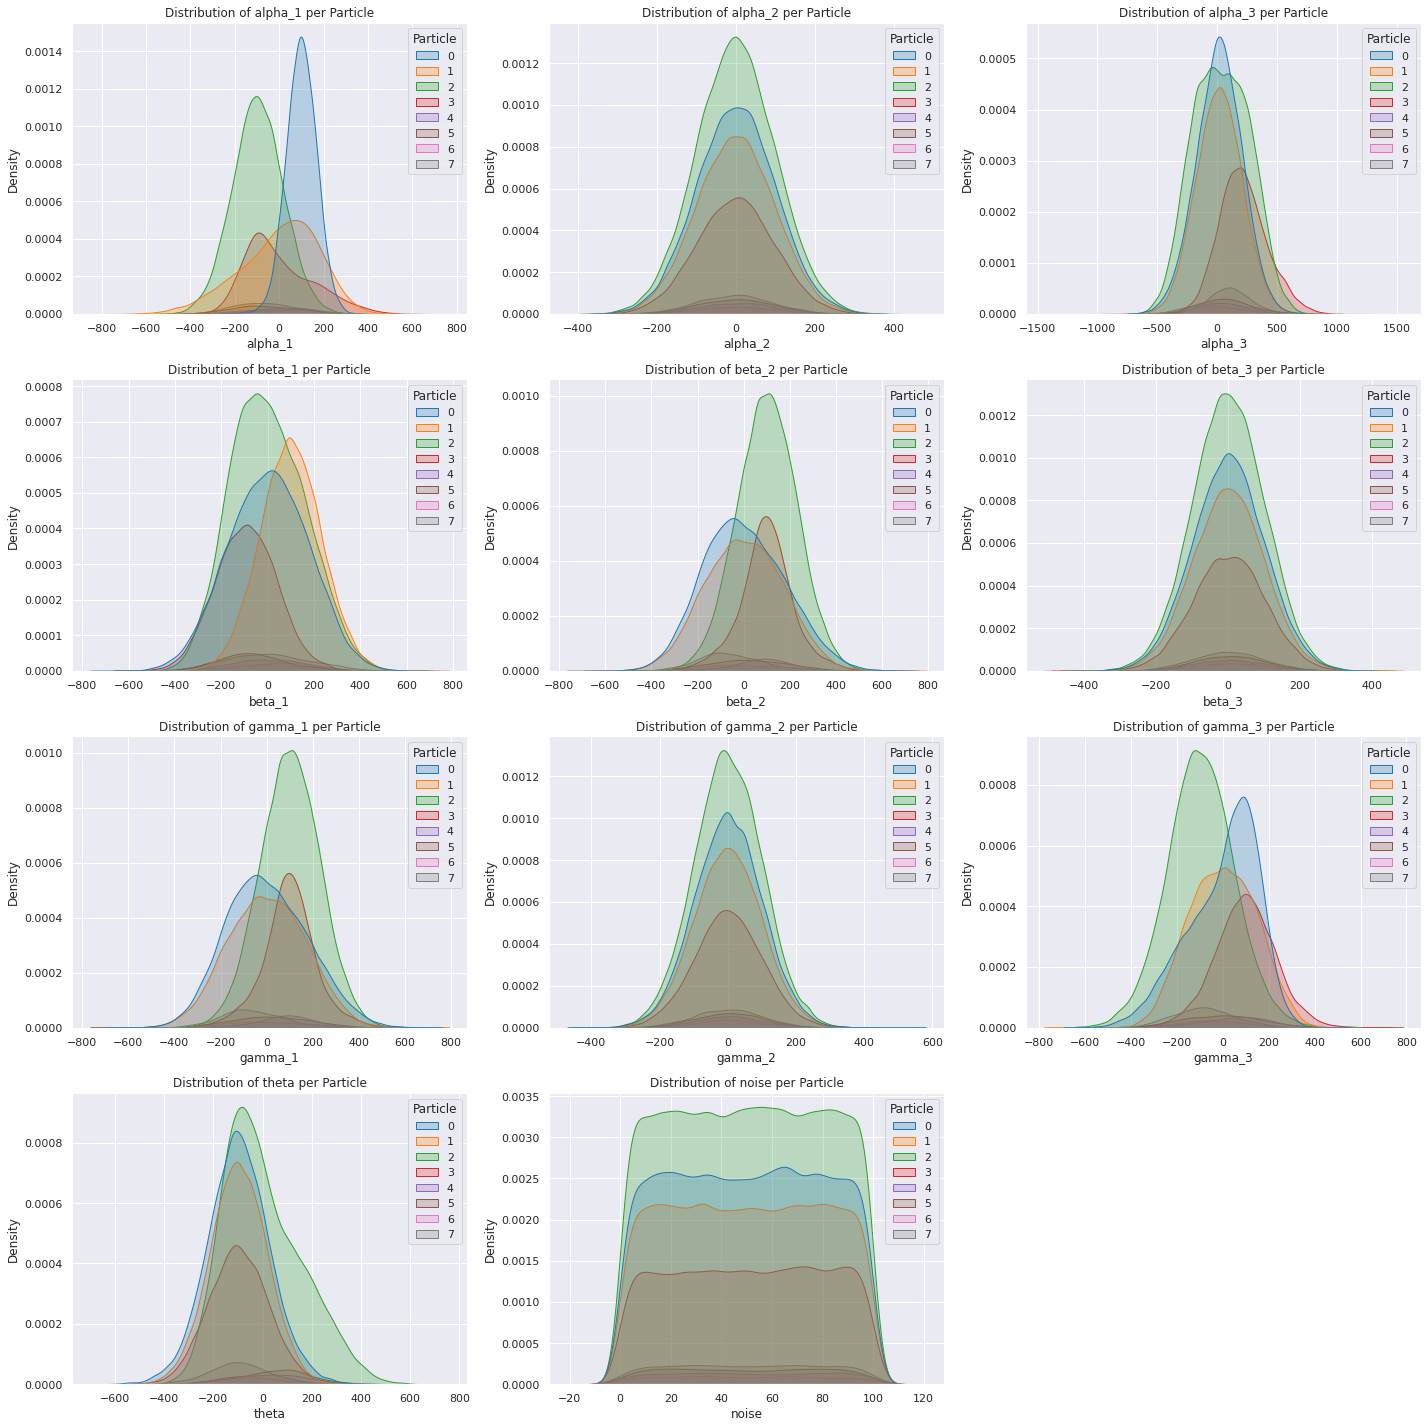

In [9]:
# make histogram plots of the variables, discriminating type of particle
column_names = data_particles.drop(columns=['Particle']).columns

# number of columns and rows of the grid of plots
ncols = 3
nrows = int(np.ceil(len(column_names) / ncols))

fig = plt.figure(figsize=(20, 20))

# iterate through all the variables
for i, col in enumerate(column_names):
    # add a subplot in the (i+1)th position
    ax = fig.add_subplot(nrows, ncols, i+1)
    # plot the distribution of the variable, disaggregated per Particle
    sns.kdeplot(data=data_particles, x=col, hue='Particle', fill=True, palette='tab10', ax=ax)
    ax.set_title(f'Distribution of {col} per Particle')

plt.tight_layout()

### Correlations between variables

In [10]:
# compute the correlation matrix
data_particles_corr = data_particles.corr()
# plot the correlation matrix
data_particles_corr.style.background_gradient(cmap='coolwarm',vmin=-1, vmax=1)

,alpha_1,alpha_2,alpha_3,beta_1,beta_2,beta_3,gamma_1,gamma_2,gamma_3,theta,noise,Particle
alpha_1,1.000000,-0.000016,-0.356387,0.006568,-0.132574,0.005763,-0.132610,0.001136,0.315485,-0.125341,0.000454,-0.290475
alpha_2,-0.000016,1.000000,0.001051,0.000253,-0.004802,0.000502,-0.004744,-0.000751,-0.000862,-0.001576,0.001311,-0.004861
alpha_3,-0.356387,0.001051,1.000000,-0.584323,0.122645,-0.000564,0.122683,-0.003794,0.208080,-0.657674,0.004392,0.157332
beta_1,0.006568,0.000253,-0.584323,1.000000,-0.135107,-0.000817,-0.135118,-0.000623,0.157325,0.098054,-0.000839,-0.138840
beta_2,-0.132574,-0.004802,0.122645,-0.135107,1.000000,-0.003177,1.000000,0.004026,-0.099809,0.022734,0.001867,0.107342
beta_3,0.005763,0.000502,-0.000564,-0.000817,-0.003177,1.000000,-0.003249,-0.005284,0.007687,0.000698,-0.001978,0.004232
gamma_1,-0.132610,-0.004744,0.122683,-0.135118,1.000000,-0.003249,1.000000,0.003932,-0.099939,0.022653,0.002128,0.107423
gamma_2,0.001136,-0.000751,-0.003794,-0.000623,0.004026,-0.005284,0.003932,1.000000,-0.004616,0.004802,0.000309,0.000807
gamma_3,0.315485,-0.000862,0.208080,0.157325,-0.099809,0.007687,-0.099939,-0.004616,1.000000,-0.189019,0.004138,-0.017046
theta,-0.125341,-0.001576,-0.657674,0.098054,0.022734,0.000698,0.022653,0.004802,-0.189019,1.000000,-0.004534,0.126064


#### gamma_1 and beta_2 have a correlation of 1!

<AxesSubplot:xlabel='gamma_1', ylabel='beta_2'>

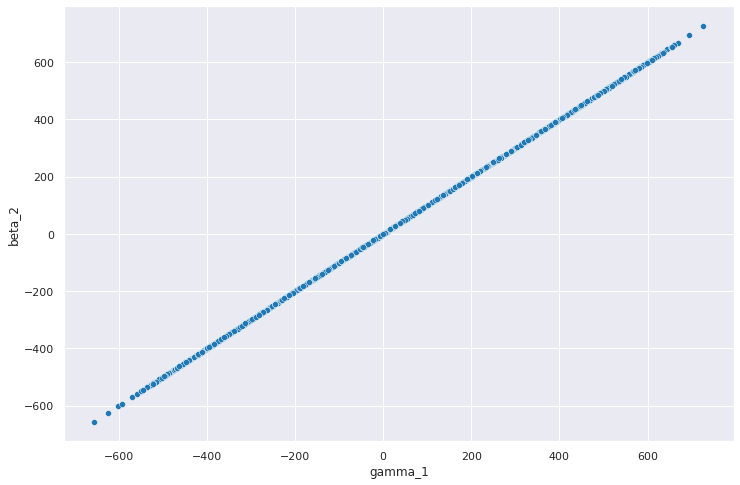

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='gamma_1', y='beta_2', data=data_particles, ax=ax)

Other variables are **mildly correlated**. Let's see those with a correlation > 0.5:

In [12]:
# define the threshold of the correlation
threshold = 0.5

# create a mask to filter the correlations that are greater than the threshold (in absolute value) and not 1
corr_mask = (data_particles_corr.abs() > threshold) & (data_particles_corr != 1)

# apply the mask
high_corr_columns = data_particles_corr[corr_mask].dropna(how='all').dropna(axis=1, how='all')
high_corr_columns

,alpha_3,beta_1,theta
alpha_3,NaN,-0.584323,-0.657674
beta_1,-0.584323,NaN,NaN
theta,-0.657674,NaN,NaN


If we graph the scatter plots for these **pairs of variables**, it's clear that they are somewhat **correlated**:

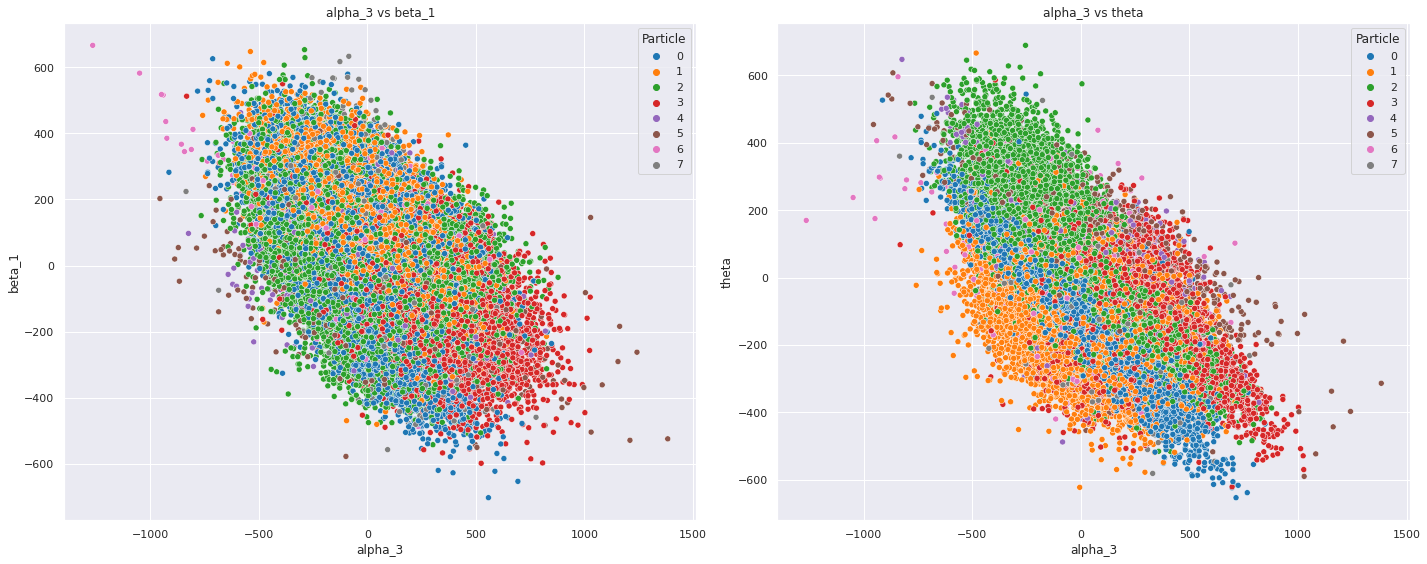

In [13]:
# define the medium correlated pairs
corr_pairs = [('alpha_3', 'beta_1'), ('alpha_3', 'theta')]

# define the number of rows and columns of the grid of plots
ncols = 2
nrows = 1

fig = plt.figure(figsize=(20, 8))
# iterate throught the correlated pairs
for i, pair in enumerate(corr_pairs):  
    ax = fig.add_subplot(nrows, ncols, i+1)
    sns.scatterplot(x=pair[0], y=pair[1], data=data_particles, hue='Particle', palette='tab10', ax=ax)
    ax.set_title(f'{pair[0]} vs {pair[1]}')

plt.tight_layout()

## Conclusions of the EDA
- The target is **imbalanced** (4 types of particle sum up to 94% of the observations).
- All the variables are **normal-like distributed**, except for *'noise'*, that has an **uniform** distribution.
- The normal-distributed variables are more or less **centered around 0**, and their **standard deviations are on the same order of magnitude**. This implies that **normalization amd standardization may be not necessary**.
- The variables *alpha_2*, *beta_3*, *gamma_2* don't change much (nor in mean, nor in distribution) from particle type to particle type. These columns could be **good candidates to drop** before building the model. 
- *gamma_1* and *beta_2* have a correlation of 1, which means we should **drop one of them**.
- 2 pairs of variables are midly correlated, so our model may be improved if we use **Principal Component Analysis** to reduce dimensions.

## Preprocessing data

I'm going to drop the gamma_1 column, because of its absolute correlation with beta_2

In [14]:
data_particles.drop(columns='gamma_1', inplace=True)

#### Substract the noise from the other variables

I thought that substracting the average noise could improve the performance of the model, but the F-score goes worse when doing this, so I'm going to skip this step

In [15]:
# columns_wout_noise = data_particles.columns.drop(['Particle', 'noise'])

# data_particles[columns_wout_noise] = data_particles[columns_wout_noise] - data_particles['noise'].values[:, None]
# data_particles.drop(columns='noise', inplace=True)

#### Divide the dataset in train and test

To divide the dataset into train and test, I'm going to use the **random seed** defined in the first cell, 42:

In [16]:
# divide the dataset in two: train and test
from sklearn.model_selection import train_test_split

X = data_particles.drop('Particle', axis=1)
y = data_particles['Particle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

#### Impute the values, first in the train dataset, and then in the test dataset

I'm going to use the **Iterative Imputer** from scikit-learn. This imputer defines the filling values as a function of the other variables in the dataset.

To use the imputer, I'm going to fit it with the *train* dataset, to **avoid leakage of information** from the *test* dataset:

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# instantiate the imputer
imp = IterativeImputer()

# fit the imputer with the train dataset
imp.fit(X_train)

# impute the NaN values in the train and test datasets
X_train = pd.DataFrame(imp.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

#### Principal component Analysis (PCA)

The Principal Component Analysis didn't enhance the F-score, so I'm going to skip this step. But an interesting insight is that 7 variables (combinations of the remaining 10 variables) are enough to represent the data:

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.9)
pca.fit(X_train)
reduced_train = pca.transform(X_train)
reduced_test = pca.transform(X_test)

pca_columns = ['column_' + str(i) for i in range(reduced_train.shape[1])]

pd.Series(pca.explained_variance_, index=pca_columns)

# X_train = pd.DataFrame(reduced_train, columns=pca_columns)
# X_test = pd.DataFrame(reduced_test, columns=pca_columns)

column_0    73023.298685
column_1    37111.431284
column_2    23660.327174
column_3    23051.699605
column_4    16057.806625
column_5    10023.999466
column_6     9971.235279
dtype: float64

#### Scale (or not) the variables
I'm not going to scale the variables, because the variable distributions are within the same order of magnitude, so the risk of one variable biasing the model is very low. Also, the **tree-based models** I am going to use **don't require scaling, in general**.

## Models

Now that the data is prepared, let's start building some models. I'm going to **store the f1 score of each model** to compare them:

In [19]:
from sklearn.metrics import f1_score
f1score = {}

### Baseline - Logistic regression

To have a baseline model, I'm going to start with a Logistic Regression:

In [20]:
from sklearn.linear_model import LogisticRegression

def fit_predict_lr(X_train, y_train, X_test, class_weight=None):
    '''Fits and predicts the provided data using the Logistic Regression model
    Args:
     X_train (array-like of shape (n_samples, n_features)): The features from the train dataset
     y_train (array-like of shape (n_samples, 1)): The target from the train dataset
     X_test (array-like of shape (n_samples, n_features)): The features from the test dataset
     class_weight (string, default None): Use 'balanced' to add weights to the classes and correct their imbalance

     Returns:
     y_pred (array of shape (n_samples, 1)): The target prediction for the test dataset  
    '''
    # instantiate the Logistic Regression model
    model = LogisticRegression(max_iter=5000, class_weight=class_weight)
    # fit the model
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    
    return y_pred

In [21]:
# store the predictions for the Logistic Regression
y_pred_lr = fit_predict_lr(X_train, y_train, X_test) 
# compute the f1 score for the Logistic Regression and store it for later
f1score['logistic'] = f1_score(y_test, y_pred_lr, average='macro')

Let's also try this model with balanced class weights, and see if it improves

In [22]:
# store the predictions for the balanced Logistic Regression
y_pred_lr_b = fit_predict_lr(X_train, y_train, X_test, class_weight='balanced')
# compute the f1 score
f1score['logistic-balanced'] = f1_score(y_test, y_pred_lr_b, average='macro')

### Random forest

Now, let's try using a Random Forest model, with the default hyperparameters

In [23]:
from sklearn.ensemble import RandomForestClassifier

def fit_predict_rf(X_train, y_train, X_test, class_weight=None):
    '''Fits and predicts the provided data using the Random Forest model
    Args:
     X_train (array-like of shape (n_samples, n_features)): The features from the train dataset
     y_train (array-like of shape (n_samples, 1)): The target from the train dataset
     X_test (array-like of shape (n_samples, n_features)): The features from the test dataset
     class_weight (string, default None): Use 'balanced' to add weights to the classes and correct their imbalance

     Returns:
     y_pred (array of shape (n_samples, 1)): The target prediction for the test dataset  
    '''
    # instantiate the Random Forest model
    model = RandomForestClassifier(class_weight=class_weight)
    # fit the model
    model.fit(X_train, y_train)
    # predict
    y_pred = model.predict(X_test)
    
    return y_pred

In [24]:
# store the predictions for the Random Forest
y_pred_rf = fit_predict_rf(X_train, y_train, X_test) 
# compute and store the f1 score
f1score['random forest'] = f1_score(y_test, y_pred_rf, average='macro')

In [25]:
# store the predictions for the Random Forest (balanced)
y_pred_rf_b = fit_predict_rf(X_train, y_train, X_test, class_weight='balanced') 
# compute and store the f1 score
f1score['random forest-balanced'] = f1_score(y_test, y_pred_rf_b, average='macro')

The f1 score values for this two classifiers show that the Random Forest reaches a better fit, and that adding weights to the classes to balance them doesn't improve the models:

In [26]:
pd.Series(f1score)

logistic                  0.276684
logistic-balanced         0.275889
random forest             0.552299
random forest-balanced    0.544848
dtype: float64

### XGBoost

Let's try another model, the XGBoost model

In [27]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

def fit_predict_xgb(X_train, y_train, X_test, class_weight=None):
    '''Fits and predicts the provided data using the Logistic Regression model
    Args:
     X_train (array-like of shape (n_samples, n_features)): The features from the train dataset
     y_train (array-like of shape (n_samples, 1)): The target from the train dataset
     X_test (array-like of shape (n_samples, n_features)): The features from the test dataset
     class_weight (string, default None): Use 'balanced' to add weights to the classes and correct their imbalance

     Returns:
     y_pred (array of shape (n_samples, 1)): The target prediction for the test dataset  
    '''
    # instantiate the model
    model = XGBClassifier()
    # compute the weights to pass to the XGBoost model
    classes_weights = compute_sample_weight(class_weight=class_weight, y=y_train)
    # fit the model
    model.fit(X_train, y_train, sample_weight=classes_weights)
    # predict
    y_pred = model.predict(X_test)
    
    return y_pred

In [28]:
# store the predictions for the XGBoost
y_pred_xgb = fit_predict_xgb(X_train, y_train, X_test)
# compute the f1 score
f1score['XGB'] = f1_score(y_test, y_pred_xgb, average='macro')

In [29]:
# store the predictions for the XGBoost (balanced)
y_pred_xgb_b = fit_predict_xgb(X_train, y_train, X_test, class_weight='balanced')
# compute the f1 score
f1score['XGB-balanced'] = f1_score(y_test, y_pred_xgb_b, average='macro')

In [30]:
pd.Series(f1score)

logistic                  0.276684
logistic-balanced         0.275889
random forest             0.552299
random forest-balanced    0.544848
XGB                       0.562956
XGB-balanced              0.542795
dtype: float64

From this results, the **random forest with default hyperparameters has the best f1-score** (macro)

#### Feature importance with XGBoost

Let's see if we can improve this model by dropping variables with less importance in the fitting. To do that, I'm going to see which variables are more important for a XGBoost model:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

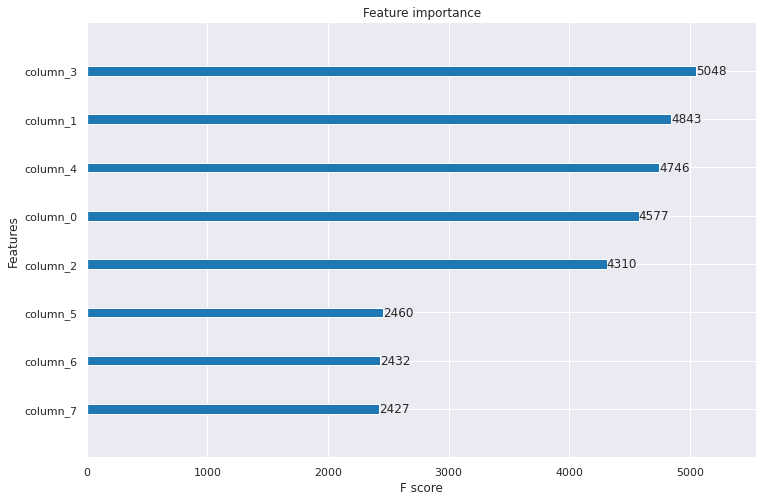

In [31]:
from xgboost import plot_importance

# fit a XGBoost model to use the feature importances yielded by the fit
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# plot the XGBoost feature importances
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(xgb_model, ax=ax)

I'm going to drop the *'alpha_2'*, *'beta_3'*, *'gamma_2'* and *'noise'* columns because they have **smaller feature imporances**, but also because we saw in the **violin plots** that this columns **don't vary much from one type of particle to another**.

In [33]:
#columns_to_drop = ['alpha_2', 'beta_3', 'gamma_2', 'noise']
columns_to_drop = ['column_5', 'column_6', 'column_7']

# drop the columns, in place
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

Now, I'll apply the **random forest** model:

In [34]:
# predictions for Random Forest model, after dropping the 4 columns above
y_pred_rf_drop = fit_predict_rf(X_train, y_train, X_test) 
# compute the f1 score
f1score['random forest-dropped vars'] = f1_score(y_test, y_pred_rf_drop, average='macro')

And the **XGBoost** model:

In [35]:
# predictions for XGBoost model, after dropping the 4 columns above
y_pred_xgb_drop = fit_predict_xgb(X_train, y_train, X_test) 
# compute the f1 score
f1score['XGB-dropped vars'] = f1_score(y_test, y_pred_xgb_drop, average='macro')

In [36]:
pd.Series(f1score)

logistic                      0.276684
logistic-balanced             0.275889
random forest                 0.552299
random forest-balanced        0.544848
XGB                           0.562956
XGB-balanced                  0.542795
random forest-dropped vars    0.589537
XGB-dropped vars              0.570862
dtype: float64

The models **improve after dropping those variables**. The random forest is still the model with the best f1 score

### Model hyperparameters tuning
I'm going to increase the number of trees (n_estimators) from the default (100) to 250 

In [37]:
# increase the number of trees
model = RandomForestClassifier(n_estimators=250)

# fit the model
model.fit(X_train, y_train)
# predict
y_pred_rf_tuned = model.predict(X_test)
       
# compute the f1 score
f1score['random forest-tuned_hyperp'] = f1_score(y_test, y_pred_rf_tuned, average='macro')

In [38]:
pd.Series(f1score)

logistic                      0.276684
logistic-balanced             0.275889
random forest                 0.552299
random forest-balanced        0.544848
XGB                           0.562956
XGB-balanced                  0.542795
random forest-dropped vars    0.589537
XGB-dropped vars              0.570862
random forest-tuned_hyperp    0.588842
dtype: float64

There is **not an improvement** in the f1 score by increasing the number of trees in the model.

### Cross-validation

Let's check if there is overfitting in the best model so far. To do that, I'm going to cross-validate the random forest (after dropping the 4 least important columns) using StratifiedKFold

In [39]:
# # drop the columns (before, I dropped them on the X_train, X_test dataset separately)
# columns_to_drop = ['alpha_2', 'beta_3', 'gamma_2', 'noise']
# X.drop(columns=columns_to_drop, inplace=True)

In [45]:
from sklearn.model_selection import StratifiedKFold

cross_val_f1score = []

kfold = StratifiedKFold(random_state=random_seed, n_splits=10, shuffle=True)

columns_to_drop = ['column_5', 'column_6', 'column_7']

for train_idx, test_idx in kfold.split(X, y):
    # divide the data into train and test, using the indexes from the fold
    X_train_k, y_train_k = X.iloc[train_idx], y.iloc[train_idx]
    X_test_k, y_test_k = X.iloc[test_idx], y.iloc[test_idx]
    
    # impute values
    imp = IterativeImputer()
    imp.fit(X_train_k)
    X_train_k = pd.DataFrame(imp.transform(X_train_k), columns=X_train_k.columns)
    X_test_k = pd.DataFrame(imp.transform(X_test_k), columns=X_test_k.columns)
    
    # pca
    reduced_train = pca.transform(X_train_k)
    reduced_test = pca.transform(X_test_k)
    X_train_k = pd.DataFrame(reduced_train, columns=pca_columns)
    X_test_k = pd.DataFrame(reduced_test, columns=pca_columns)

    # drop columns
    X_train_k.drop(columns=columns_to_drop, inplace=True)
    X_test_k.drop(columns=columns_to_drop, inplace=True)

    # print the proportion of the particle classes, to check if the fold is representative of the total data
    print(f'Proportion of particles in fold: {y_train.value_counts(normalize=True).sort_index().round(decimals=4).to_dict()}')

    # instantiate the Random Foreset model
    rf_model = RandomForestClassifier()
    # fit the model
    rf_model.fit(X_train_k, y_train_k)
    
    # predict
    y_pred = rf_model.predict(X_test_k)
    cross_val_f1score.append(f1_score(y_test_k, y_pred, average='macro'))
    
print(f'Cross validation f1 score per fold: {cross_val_f1score}')
print(f'Average cross validation f1 score: {np.mean(cross_val_f1score)}')
print(f'Standard deviation cross validation f1 score: {np.std(cross_val_f1score)}')

Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold: {0: 0.2522, 1: 0.2158, 2: 0.3299, 3: 0.1398, 4: 0.013, 5: 0.0176, 6: 0.0092, 7: 0.0224}
Proportion of particles in fold:

## Final predictions with Random Forest

We can see how well the best model predicted the classes with a bar plot of the prediction vs. the test sample

The best model characteristics are:
- It's a Random Forest model, with default hyperparameters
- I've dropped the *'alpha_2'*, *'beta_3'*, *'gamma_2'*, *'noise'* columns

In [46]:
y_pred = pd.DataFrame(y_pred_rf_drop)

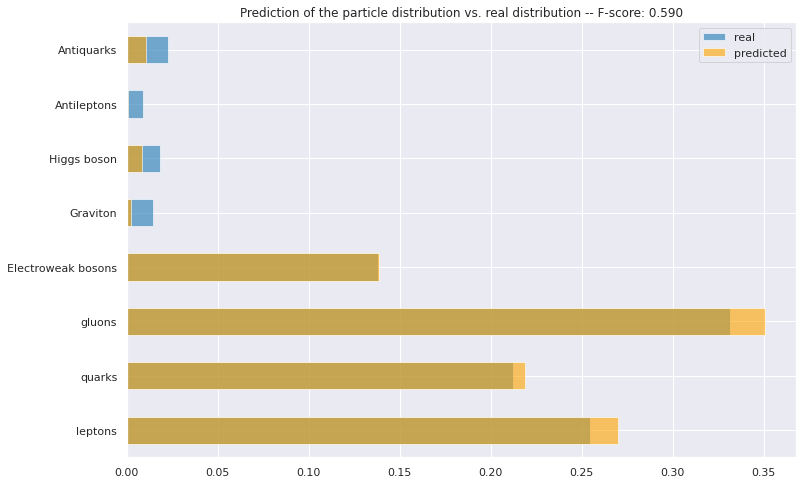

In [47]:
fig, ax = plt.subplots(figsize=(12,8))

# plot the distribution of the particles in the test dataset
y_test.value_counts(normalize=True).sort_index().plot(kind='barh', label='real', alpha=0.6, ax=ax)

# plot the distribution of the particles in the predicted dataset: Random Forest model, with 4 dropped columns
y_pred.value_counts(normalize=True).sort_index().plot(kind='barh', label='predicted', color='orange', alpha=0.6,  ax=ax)

# Use the real names of the particles as labels
ax.set_yticklabels(map_type_particles.values())
ax.set_ylabel('')
plt.title(f'Prediction of the particle distribution vs. real distribution -- F-score: {f1score["random forest-dropped vars"]:.3f}')

plt.legend()

Due to the imbalance in the target (*'Particle'*), the **less populated classes are under-predicted**, and the more populated classes are over-predicted